## Quick look picture

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

PIL mode: P
PIL mode: L


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/4022986451.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


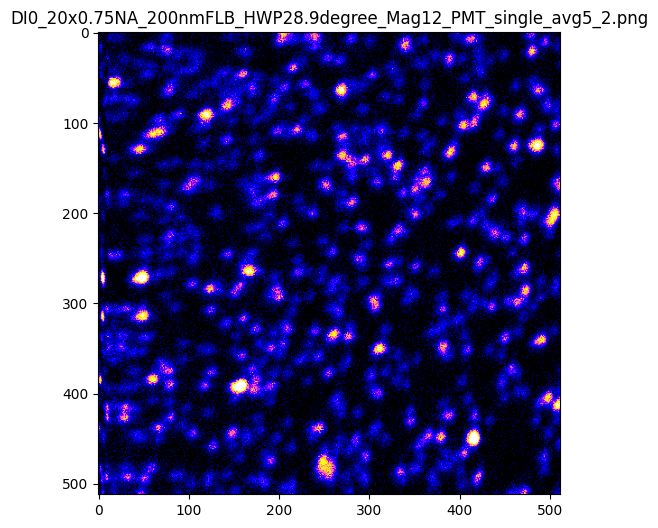

In [2]:
# open PNG image plot with matplotlib
fileDir = './4_data/trainning/200nm/'
fileName = 'DI0_20x0.75NA_200nmFLB_HWP28.9degree_Mag12_PMT_single_avg5_2.png'



img = Image.open(fileDir + fileName)
print("PIL mode:", img.mode) # mode 屬性會告訴你色彩模式

img = img.convert('L')  # convert to grayscale
print("PIL mode:", img.mode)
img_array = np.array(img)
fig1, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_array, cmap='gnuplot2')
ax.set_title(fileName)
fig1.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/3907055257.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


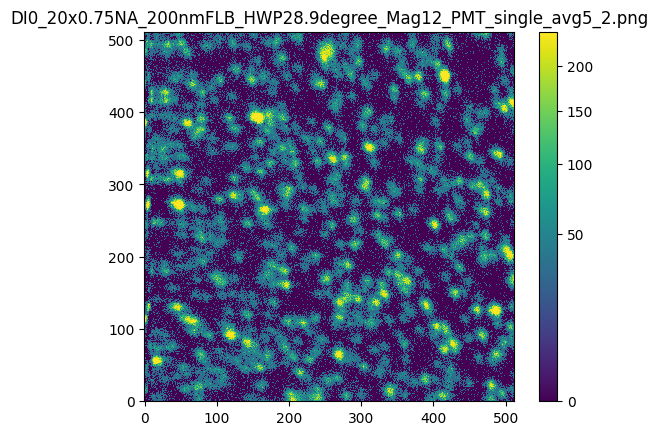

In [3]:
from vidualize import plot_picture

fig, ax = plot_picture(img_array, percent= 99.5)
ax.set_title(fileName)
fig.show()

## Background extract

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/1419233777.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


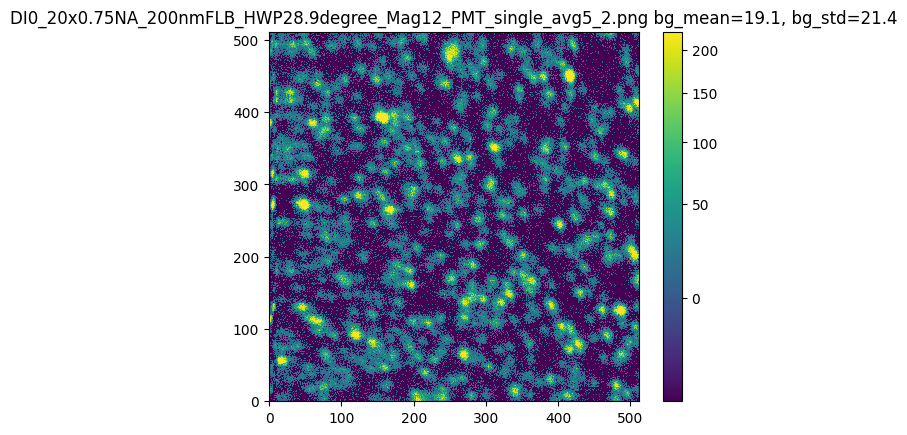

In [4]:
# viw the region that > bg_mean + kappa*std -> source
# let it be a great value to see it
from kapasigmaClip import kappaSigmaClipping

mask, bg_mean, bg_std = kappaSigmaClipping(3, 20, img_array)
image_clean_bg = img_array - bg_mean # remove background mean
fig, ax = plot_picture(image_clean_bg, percent= 99.5)
ax.set_title(fileName + f' bg_mean={bg_mean:.1f}, bg_std={bg_std:.1f}')
fig.show()


## Find source

In [5]:
from findSource import find_source, plot_source

sources = find_source(image_clean_bg, sigma=3, fwhm=8.0, threshold_times=2)
print(f"Found {len(sources)} sources")

Found 260 sources


## Plot source hold radius

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/2723434240.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


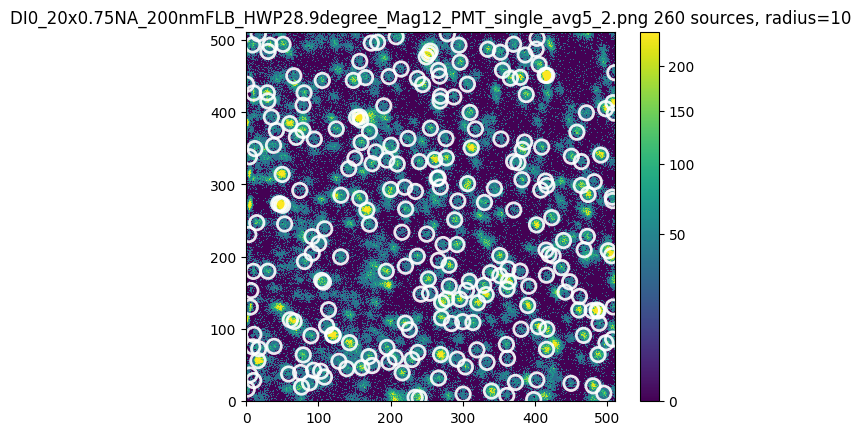

In [6]:
radius = 10
fig, ax = plot_source(img_array, sources, radius=radius, percent=99.5)
ax.set_title(f'{fileName} {len(sources)} sources, radius={radius}') 
fig.show()

## FWHM 2D fitting
Use a fix size square area (ex: 12 * 12 pixels) to fit 2D gaussian, 
the sixe of square nedd to guess based on image.

astropy.modeling models Gaussian2D
since we don't know fwhm, the fitting iteration is high, in this case = 10000

In [7]:
from fwhm2d import FWHM2d


fwhm_x_list, fwhm_y_list, mask = FWHM2d(sources, img_array, sub_size_half=9)
sources['x_fwhm'] = fwhm_x_list
sources['y_fwhm'] = fwhm_y_list
sources = sources[mask]  # only keep the sources with valid FWHM


dict_keys(['nfev', 'fvec', 'fjac', 'ipvt', 'qtf', 'message', 'ierr', 'param_jac', 'param_cov', 'njev', 'cov_x'])
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
1


Text(0.5, 1.0, 'DI0_20x0.75NA_200nmFLB_HWP28.9degree_Mag12_PMT_single_avg5_2.png with FWHM elipse')

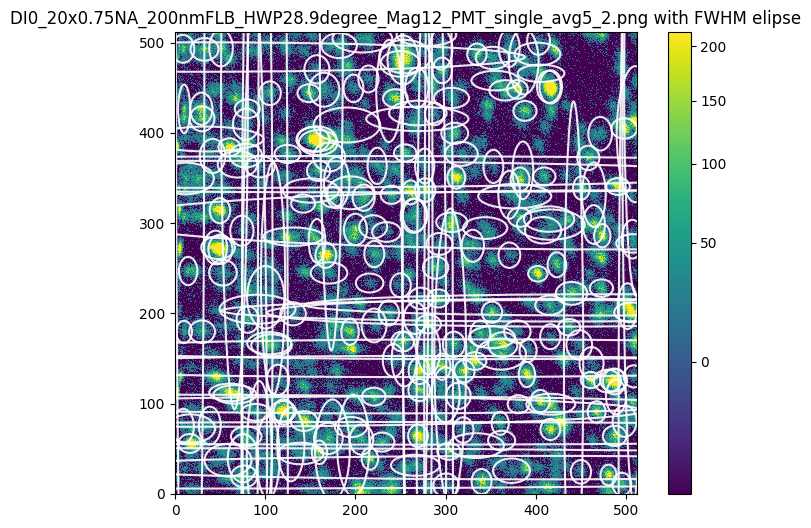

In [8]:
from fwhm2d import plot_source_fwhm_ellips

fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')

## Clean source with strange FWHM

### Plot FWHM distribution

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/675293388.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


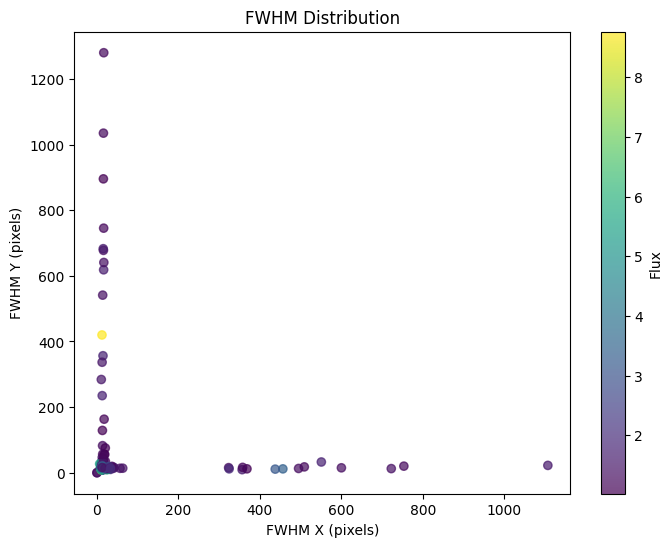

In [9]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm'], sources['y_fwhm'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

### delete FWHM > threshhold sources

Cleaned sources: 78


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/1948675915.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


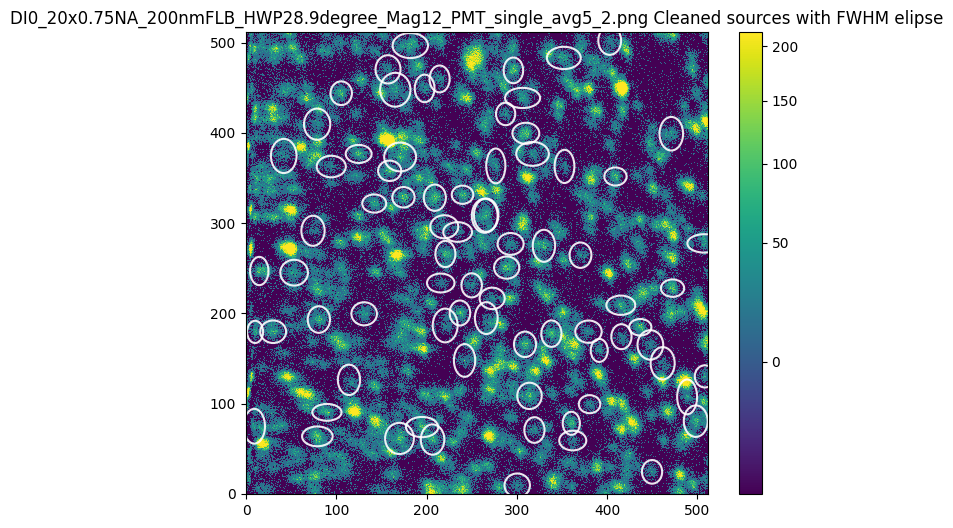

In [18]:
fwhm_threshhold_high = 20
fwhm_threshhold_low = 5
flux_threshhold_high = 3.5
mask = (
    (sources['x_fwhm'] < fwhm_threshhold_high) &
    (sources['y_fwhm'] < fwhm_threshhold_high) &
    (sources['x_fwhm'] > fwhm_threshhold_low) &
    (sources['y_fwhm'] > fwhm_threshhold_low) &
    (sources['flux'] < flux_threshhold_high)
)
source_cleaned = sources[mask]
print(f"Cleaned sources: {len(source_cleaned)}")
fig, ax = plot_source_fwhm_ellips(image_clean_bg, source_cleaned, figsize=(8, 6))
ax.set_title(f'{fileName} Cleaned sources with FWHM elipse')
fig.show()



## FWHMx y 1D fitting
Use FWHM 2D fitting result as initioal fitting parm fit again
not sure is this is necessary, but for plot 1D fitting convenience, just fit again...

### X

In [19]:
from fwhm1d import fit_gaussian_xy_new, plot_xy_cut_gaussian
rms_x_list = []
num_sources = len(sources)
axis = 'x'
avg_pixel_num = 6
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )
    rms_x_list.append(rms)

sources['rms_fit_x'] = rms_x_list
sources = sources[np.isfinite(sources['rms_fit_x'])].copy()


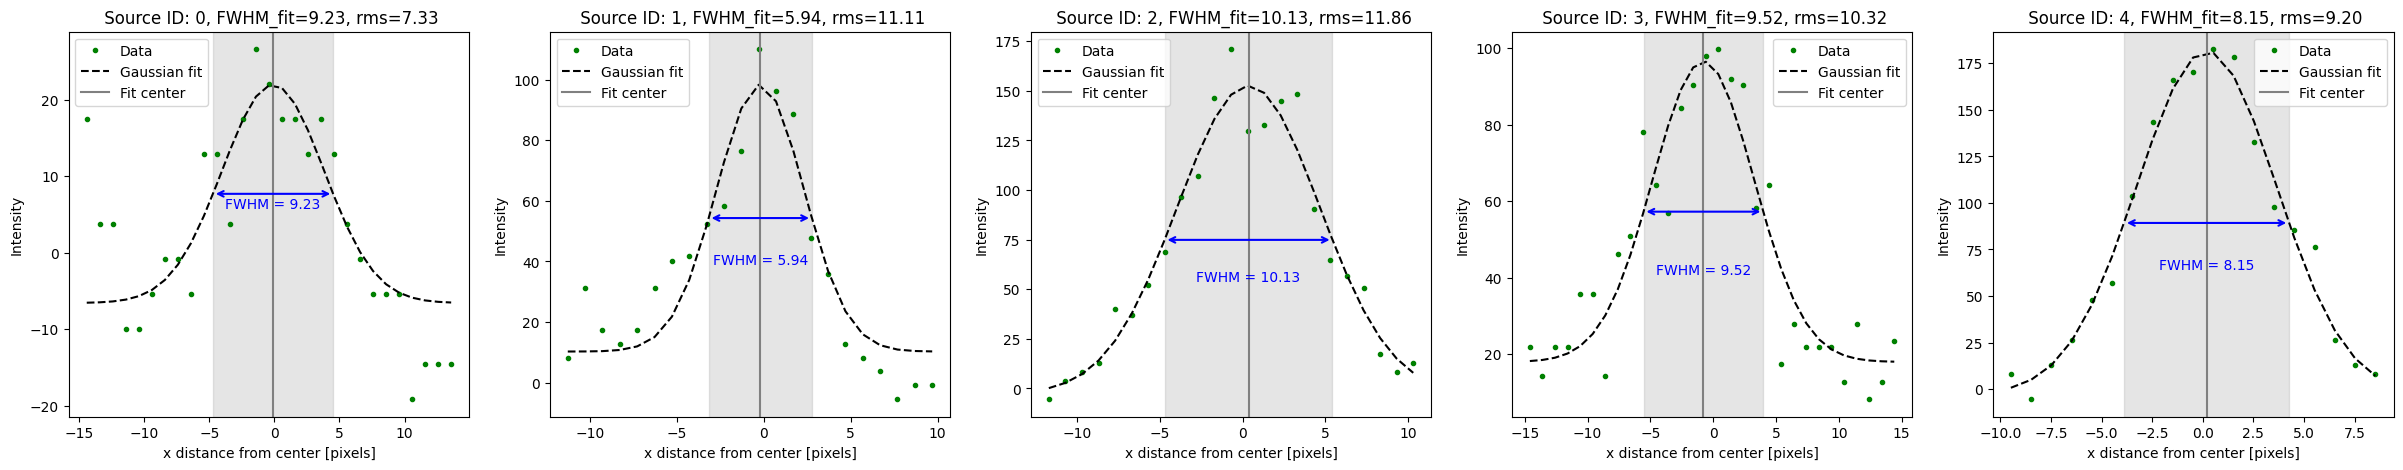

In [21]:
# plot
num_sources = len(sources)
max_plot_num = 5
axis = 'x'
num_cols = 5
num_rows = (min(max_plot_num, num_sources) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))
axes = axes.flatten()  # 將 2D 陣列展平為 1D 陣列
for i in range(min(max_plot_num, num_sources)):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )    
    fig, ax = plot_xy_cut_gaussian(
        sources, sourceID=i, parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, x0=x0, axis=axis, ax=axes[i]
    )
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")


### Y

In [33]:
from fwhm1d import fit_gaussian_xy_new, plot_xy_cut_gaussian
rms_y_list = []
num_sources = len(sources)
axis = 'y'
avg_pixel_num = 6
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )
    rms_y_list.append(rms)

sources['rms_fit_y'] = rms_y_list
sources = sources[np.isfinite(sources['rms_fit_y'])].copy()


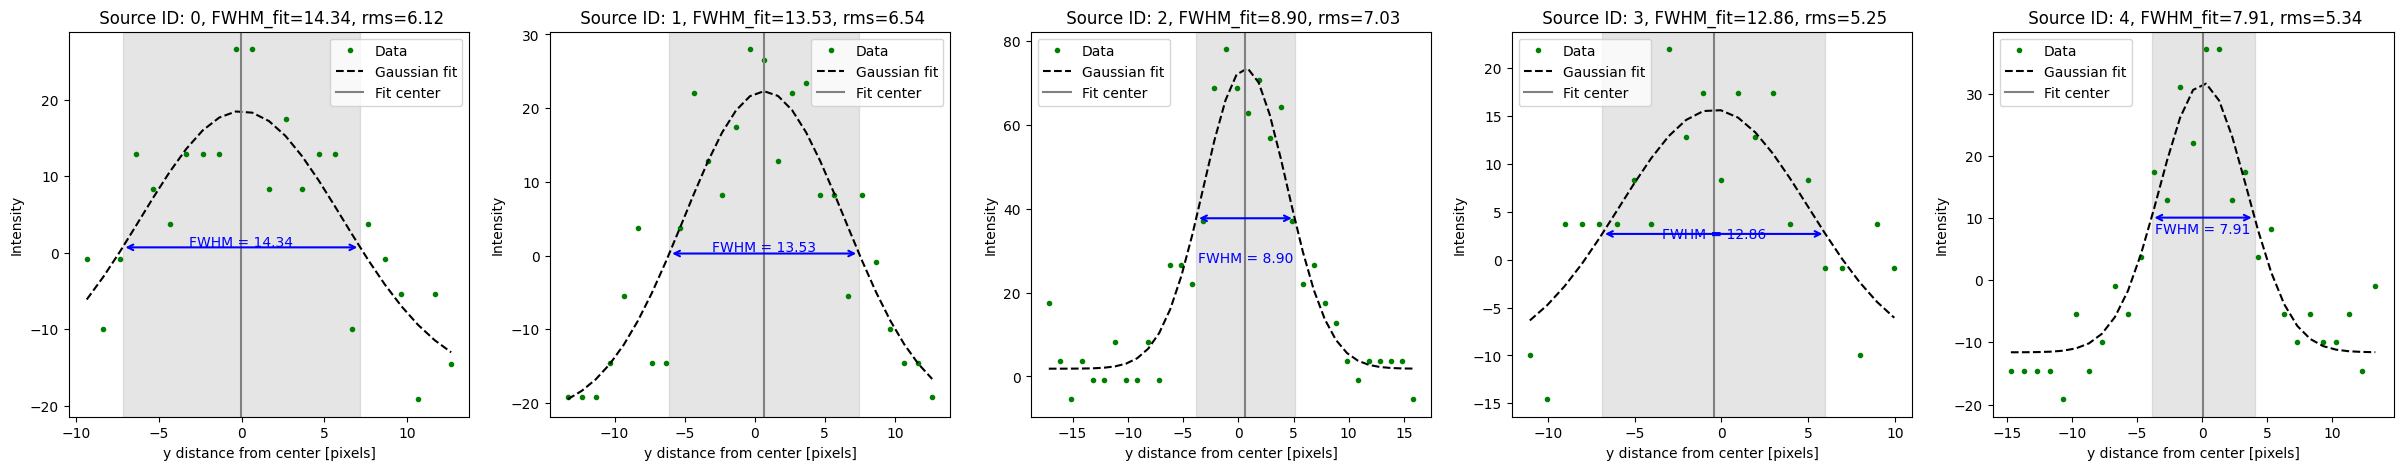

In [59]:
# plot
num_sources = len(sources)
max_plot_num = 5
axis = 'y'
num_cols = 5
num_rows = (min(max_plot_num, num_sources) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))
axes = axes.flatten()  # 將 2D 陣列展平為 1D 陣列
for i in range(min(max_plot_num, num_sources)):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )    
    fig, ax = plot_xy_cut_gaussian(
        sources, sourceID=i, parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, x0=x0, axis=axis, ax=axes[i]
    )
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/3205519490.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


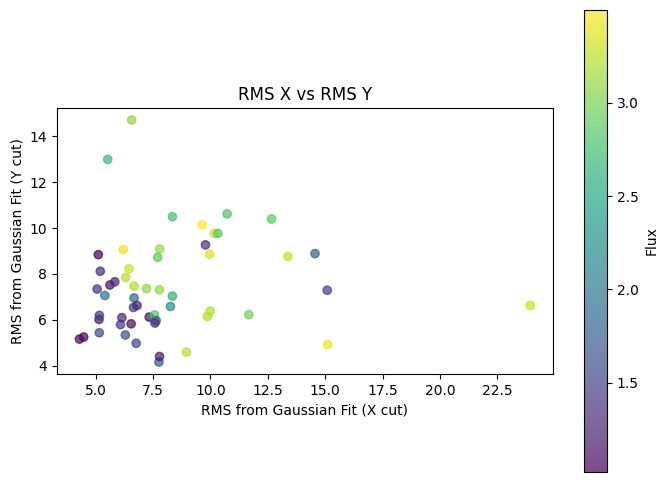

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['rms_fit_x'], sources['rms_fit_y'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('RMS from Gaussian Fit (X cut)')
ax.set_ylabel('RMS from Gaussian Fit (Y cut)')
ax.set_title('RMS X vs RMS Y')
# let x y scale same
ax.set_aspect('equal', 'box')

fig.show()

### Clean again

Cleaned sources: 54


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/2964608650.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


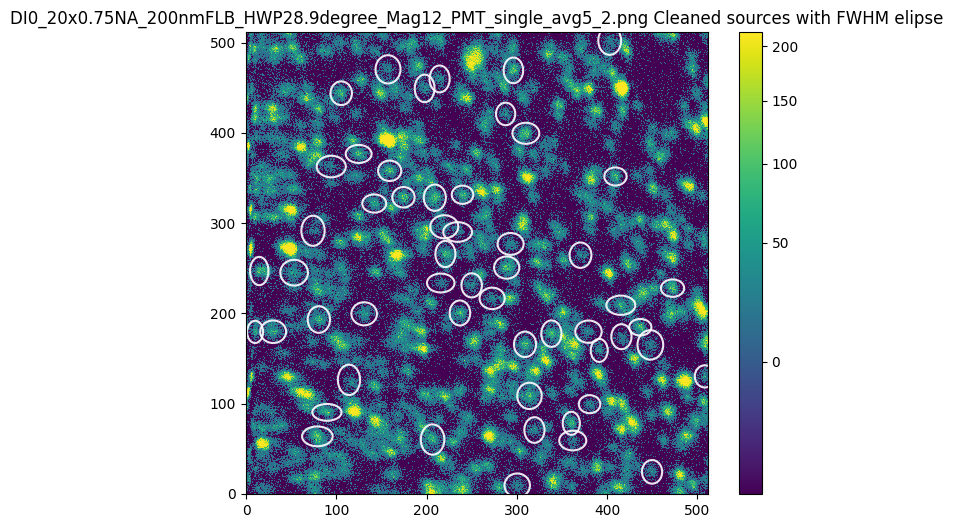

In [35]:
fwhm_threshhold_high = 20
fwhm_threshhold_low = 5
flux_threshhold_high = 3.5
mask = (
    (sources['x_fwhm'] < fwhm_threshhold_high) &
    (sources['y_fwhm'] < fwhm_threshhold_high) &
    (sources['x_fwhm'] > fwhm_threshhold_low) &
    (sources['y_fwhm'] > fwhm_threshhold_low) &
    (sources['flux'] < flux_threshhold_high)
)
sources = sources[mask]
print(f"Cleaned sources: {len(sources)}")
fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
ax.set_title(f'{fileName} Cleaned sources with FWHM elipse')
fig.show()



/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/313886698.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


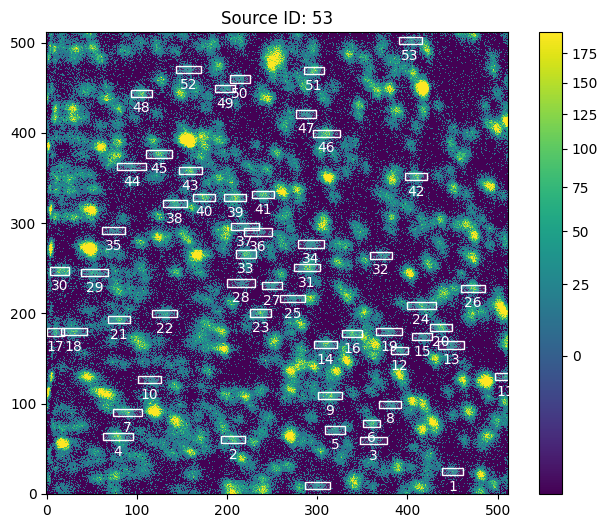

In [36]:
import matplotlib.patches as patches

source_id = 1
fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(sources)):
    source_id = i
    x0, y0, x_half_range, y_half_range = sources[source_id]['xcentroid'], sources[source_id]['ycentroid'], sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.set_title('Source ID: {}'.format(source_id))
    fig1.show()

## FWHM calculation

### FOV by measured

In [49]:
# mag = 12, 12141 pixel/mm
mag = 12
pixel_len = 1000 / 12141 # um <- measured
img_dim = 512
FOV_cut = pixel_len * img_dim
print(f"Pixel size: {pixel_len:.2f} um")
print(f"FOV: {FOV_cut * mag:.2f} um")
fwhm_x_mean = np.average(sources['x_fwhm'])*pixel_len # um
fwhm_y_mean = np.average(sources['y_fwhm'])*pixel_len # um
fwhm_x_std = np.std(sources['x_fwhm'])*pixel_len # um
fwhm_y_std = np.std(sources['y_fwhm'])*pixel_len # um
print(f"Average FWHM X: {fwhm_x_mean:.4f} um ± {fwhm_x_std:.4f} um")
print(f"Average FWHM Y: {fwhm_y_mean:.4f} um ± {fwhm_y_std:.4f} um")



Pixel size: 0.08 um
FOV: 506.05 um
Average FWHM X: 1.0612 um ± 0.1447 um
Average FWHM Y: 1.0662 um ± 0.1703 um


In [ ]:

FOV = 510.6 # um <- theory FOV
Mag = 12
img_dim = 512
pixel_len = FOV/(Mag*img_dim) # um
print(f"Pixel size: {pixel_len:.2f} um") 
fwhm_x = np.average(sources['x_fwhm'])*pixel_len # um
fwhm_y = np.average(sources['y_fwhm'])*pixel_len #
print(f"Average FWHM X: {fwhm_x:.4f} um, {np.average(sources['x_fwhm'])} pixels")
print(f"Average FWHM Y: {fwhm_y:.4f} um, {np.average(sources['y_fwhm'])} pixels")

Pixel size: 0.08 um
Average FWHM X: 1.0707 um, 12.884065931072056 pixels
Average FWHM Y: 1.0757 um, 12.944143013639273 pixels


In [45]:
wave_len = 920 # nm
# arctan(d/2f) d: 光斑直徑 f 物鏡焦距 <- theta
# NA = n*sin(theta)
d = 8.5 # mm
f = 180/20 # mm
n = 1.0 # air
theta = np.arctan(d/(2*f)) # rad
NA = n * np.sin(theta)
print(f"Numerical Aperture NA: {NA:.3f}")
# NA = 0.75
theory_fwhm = 0.32 * wave_len / (np.sqrt(2)*NA)
print(f"Theory FWHM: {theory_fwhm:.2f} nm")

Numerical Aperture NA: 0.427
Theory FWHM: 487.52 nm


## Violin plot of FWHM x y 1D fit

(0.596078431372549, 0.4486274509803921, 0.2650980392156862)
(0.44392156862745114, 0.5309803921568628, 0.5599999999999999)


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/1206580400.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM X', 'FWHM Y'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/1206580400.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


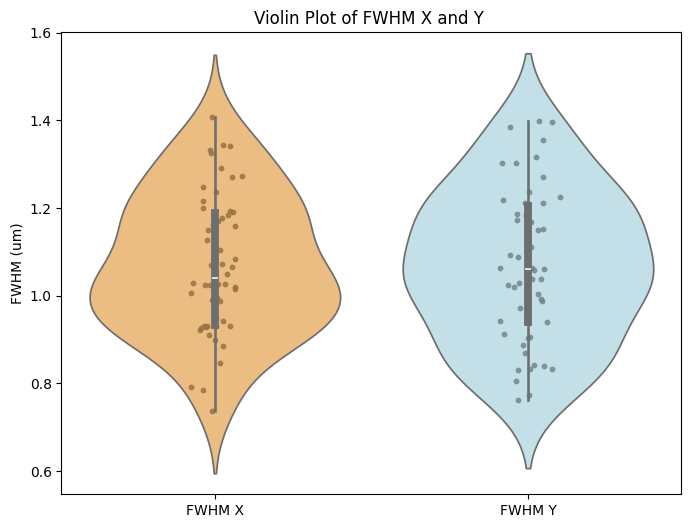

In [46]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')

pixel_len = FOV/(Mag*img_dim) # um

for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    print(dark_color)
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)

ax.set_title('Violin Plot of FWHM X and Y ')
fig.show()

## Final Source! 

In [53]:
# select mean(fwhm) +- factor*std => let meam +- > factor*std be outlier
factor = 2
fwhm_x_mean = np.mean(sources['x_fwhm'])
fwhm_x_std = np.std(sources['x_fwhm'])
fwhm_y_mean = np.mean(sources['y_fwhm'])
fwhm_y_std = np.std(sources['y_fwhm'])

mask_x = (sources['x_fwhm'] > (fwhm_x_mean - factor*fwhm_x_std)) & (sources['x_fwhm'] < (fwhm_x_mean + factor*fwhm_x_std))
mask_y = (sources['y_fwhm'] > (fwhm_y_mean - factor*fwhm_y_std)) & (sources['y_fwhm'] < (fwhm_y_mean + factor*fwhm_y_std))
mask = mask_x & mask_y
sources = sources[mask]

final_sources = sources


### elipse image plot

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/3271009537.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


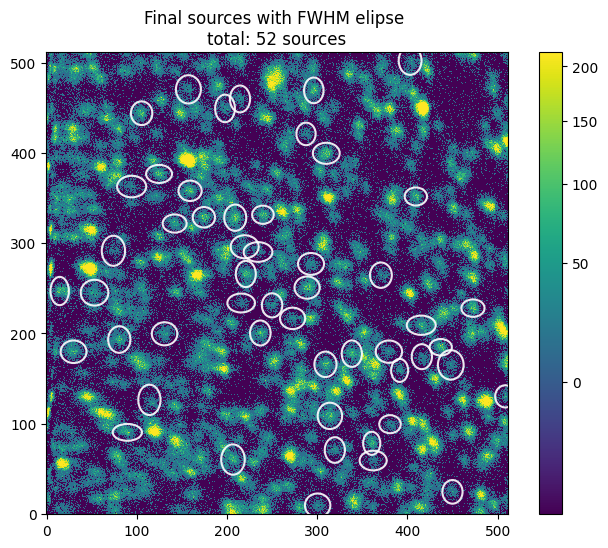

In [74]:
fig, ax = plot_source_fwhm_ellips(image_clean_bg, final_sources, figsize=(8, 6))
ax.set_title(f'Final sources with FWHM elipse \ntotal: {len(final_sources)} sources')
fig.show()

### sample rectangle

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/503631829.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


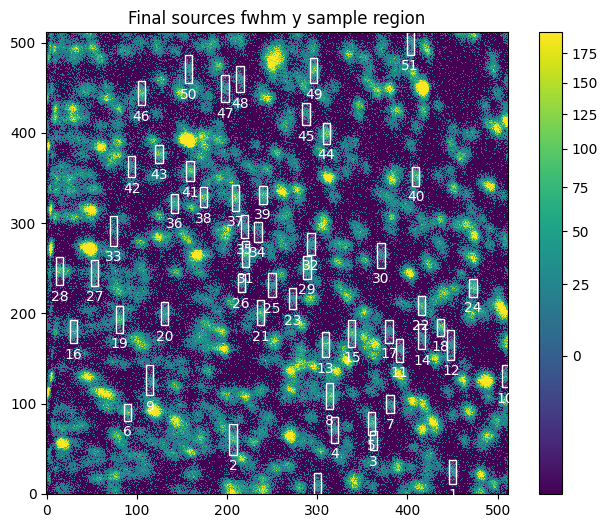

In [73]:
import matplotlib.patches as patches

fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(final_sources)):
    source_id = i
    # x fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], final_sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # y fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], avg_pixel_num//2+1, final_sources[source_id]['y_fwhm']
    rect2 = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    # ax.add_patch(rect)
    ax.add_patch(rect2)
    ax.set_title("Final sources fwhm y sample region")
    fig1.show()

### single sample x

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/3214625073.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


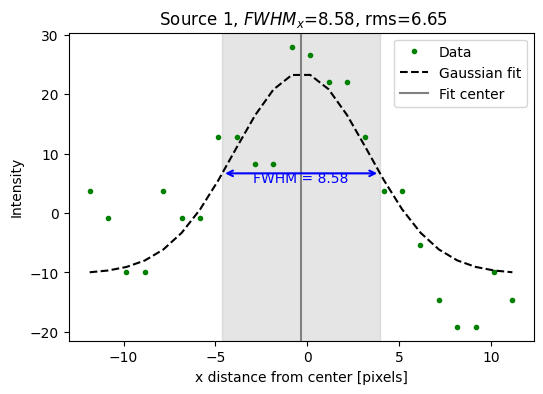

In [69]:
# plot source 1
sourceID = 1
axis = 'x'
avg_pixel_num = 6

parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=sourceID, axis=axis, avg_pixel_num=avg_pixel_num
    )
fig, ax = plot_xy_cut_gaussian(
        sources, sourceID=sourceID, parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, x0=x0, axis=axis
    )
amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
ax.set_title(f" Source {sourceID}, $FWHM_{axis}$={fwhm_fit:.2f}, rms={rms:.2f}")
fig.show()



### single sample Y

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/4143509973.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


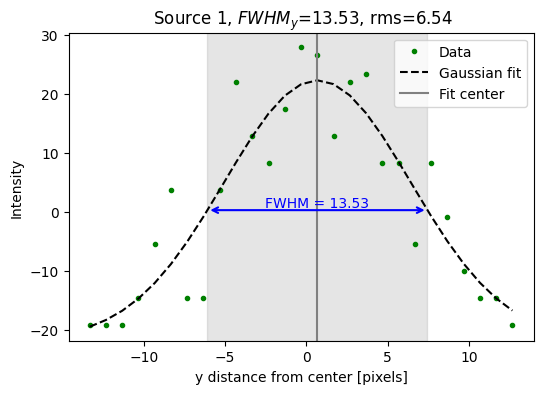

In [70]:
# plot source 1
sourceID = 1
axis = 'y'
avg_pixel_num = 6

parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=sourceID, axis=axis, avg_pixel_num=avg_pixel_num
    )
fig, ax = plot_xy_cut_gaussian(
        sources, sourceID=sourceID, parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, x0=x0, axis=axis
    )
amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
ax.set_title(f" Source {sourceID}, $FWHM_{axis}$={fwhm_fit:.2f}, rms={rms:.2f}")
fig.show()



### single sample

Cleaned FWHM X: 1.07 +- 0.15 um
Cleaned FWHM Y: 1.08 +- 0.17 um


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/3790078381.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM X', 'FWHM Y'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/3790078381.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


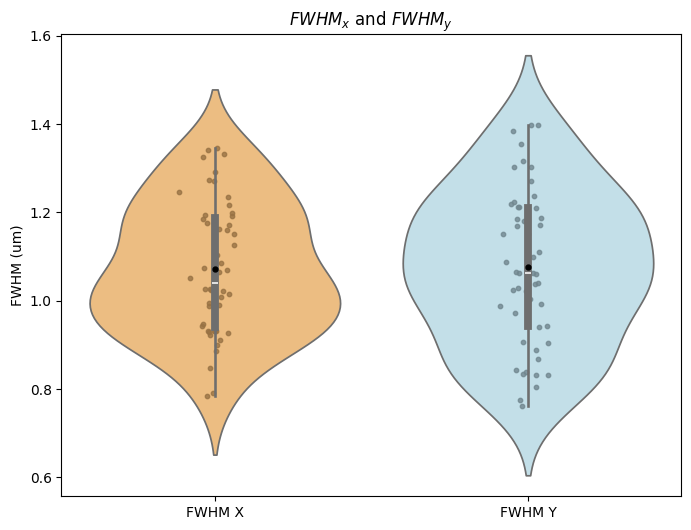

In [48]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')
# calculate mean and std
mean_y_fwhm_pixel = np.mean(sources['y_fwhm']*pixel_len)
mean_x_fwhm_pixel = np.mean(sources['x_fwhm']*pixel_len)
std_y_fwhm_pixel = np.std(sources['y_fwhm']*pixel_len)
std_x_fwhm_pixel = np.std(sources['x_fwhm']*pixel_len)
print(f"Cleaned FWHM X: {mean_x_fwhm_pixel:.2f} +- {std_x_fwhm_pixel:.2f} um")
print(f"Cleaned FWHM Y: {mean_y_fwhm_pixel:.2f} +- {std_y_fwhm_pixel:.2f} um")
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)
for i in range(len(data)):
    mean_val = np.mean(data[i])
    ax.scatter(i, mean_val, color='black', s=50, marker='.', zorder=10, label='Mean' if i == 0 else "")

ax.set_title(f'$FWHM_x$ and $FWHM_y$')
fig.show()

In [51]:
FOV = 510.6 # um <- theory FOV
Mag = 12
img_dim = 512
pixel_len = FOV/(Mag*img_dim) # um
print(f"Pixel size: {pixel_len:.2f} um") 
fwhm_x = np.average(sources['x_fwhm'])*pixel_len # um
fwhm_y = np.average(sources['y_fwhm'])*pixel_len #
print(f"Average FWHM X: {fwhm_x:.4f} um, {np.average(sources['x_fwhm'])} pixels")
print(f"Average FWHM Y: {fwhm_y:.4f} um, {np.average(sources['y_fwhm'])} pixels")

Pixel size: 0.08 um
Average FWHM X: 1.0707 um, 12.884065931072056 pixels
Average FWHM Y: 1.0757 um, 12.944143013639273 pixels


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_33356/3736678162.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


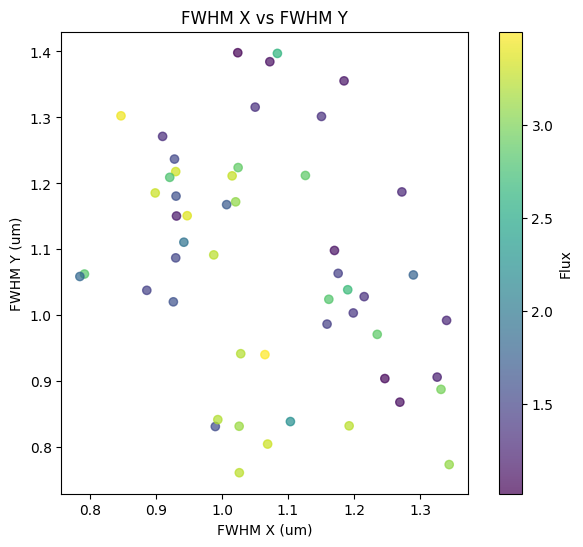

In [75]:
# plot fwhm x y scatter
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len, c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (um)')
ax.set_ylabel('FWHM Y (um)')
ax.set_title('FWHM X vs FWHM Y')
# let x y scale same
ax.set_aspect('equal', 'box')
fig.show()